In [1]:
import numpy as np
import cv2
import os,sys
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
camera_cal = './camera_cal/'
output_imgs = './output_images/'
test_imgs = './test_images/'

image size :(1280, 720)


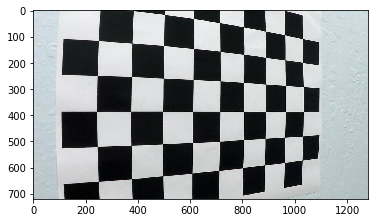

In [3]:
testimg = cv2.imread(camera_cal + 'calibration5.jpg')
nx = 9
ny = 6
imgSize = (testimg.shape[1], testimg.shape[0])
plt.imshow(testimg)
print("image size :{}".format(imgSize))


# Introduction
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Here is the my [project code](https://github.com/jaeoh2/self-driving-car-nd/CarND-Advanced-Lane-Lines-P4/Advanced-Lane-Lines.ipynb

# Camera Calibration
OpenCV functions were used to calculate the camera calibration matrix and distortion coefficients.
* Find the chessboard corners on images provided from project using findChessboardCorners function.
* Based on corners objects, we get camera calibration matrix using calibrateCamera function.
* Transform to the undistorted images using undistort function with camera calibration matrix.

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images

#Make a list of calibration images
images = glob.glob(camera_cal + 'calibration*.jpg')

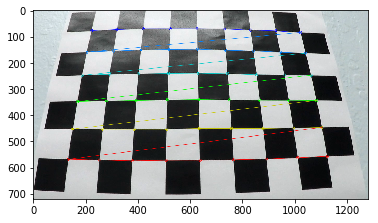

In [5]:
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    # If found, add obj points, img points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f82c4ee3fd0>,
 <matplotlib.text.Text at 0x7f82c4e64128>)

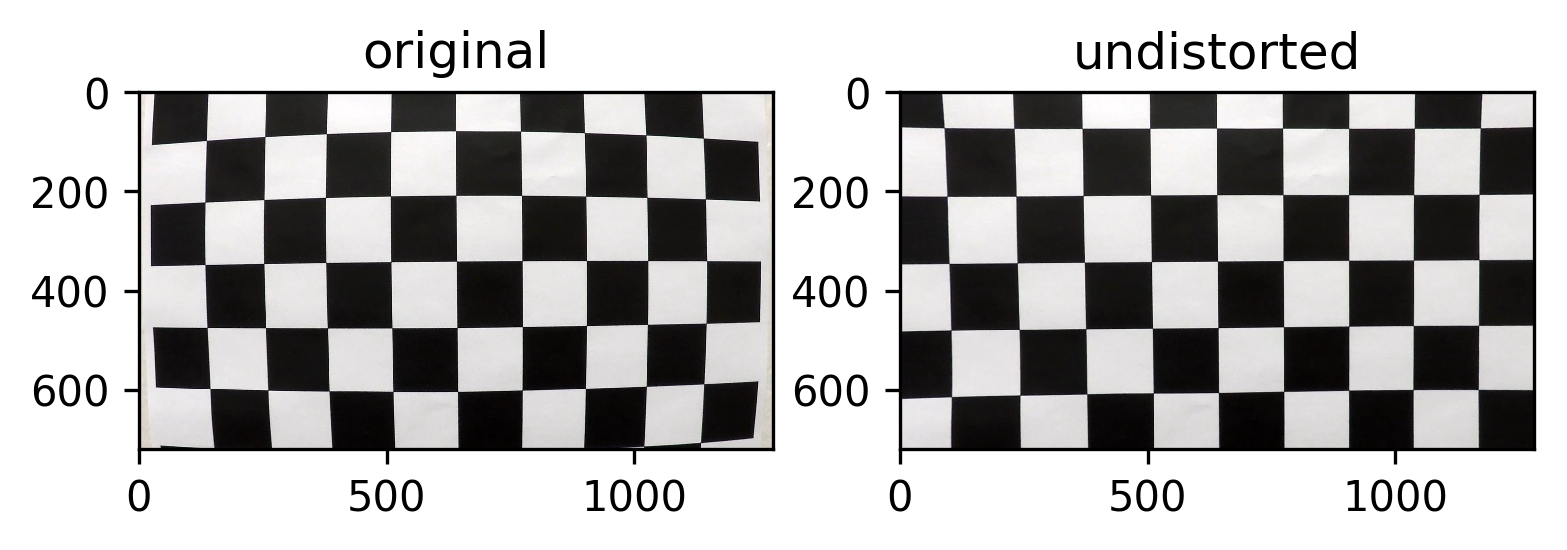

In [6]:
testImg = mpimg.imread(images[5])
imgSize = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgSize, None, None)
testDst = cv2.undistort(testImg, mtx, dist, None, mtx)

plt.figure(dpi=300)
plt.subplot(1,2,1), plt.imshow(testImg), plt.title('original')
plt.subplot(1,2,2), plt.imshow(testDst), plt.title('undistorted')


(<matplotlib.axes._subplots.AxesSubplot at 0x7f82c4f4f518>,
 <matplotlib.text.Text at 0x7f82c0274ba8>)

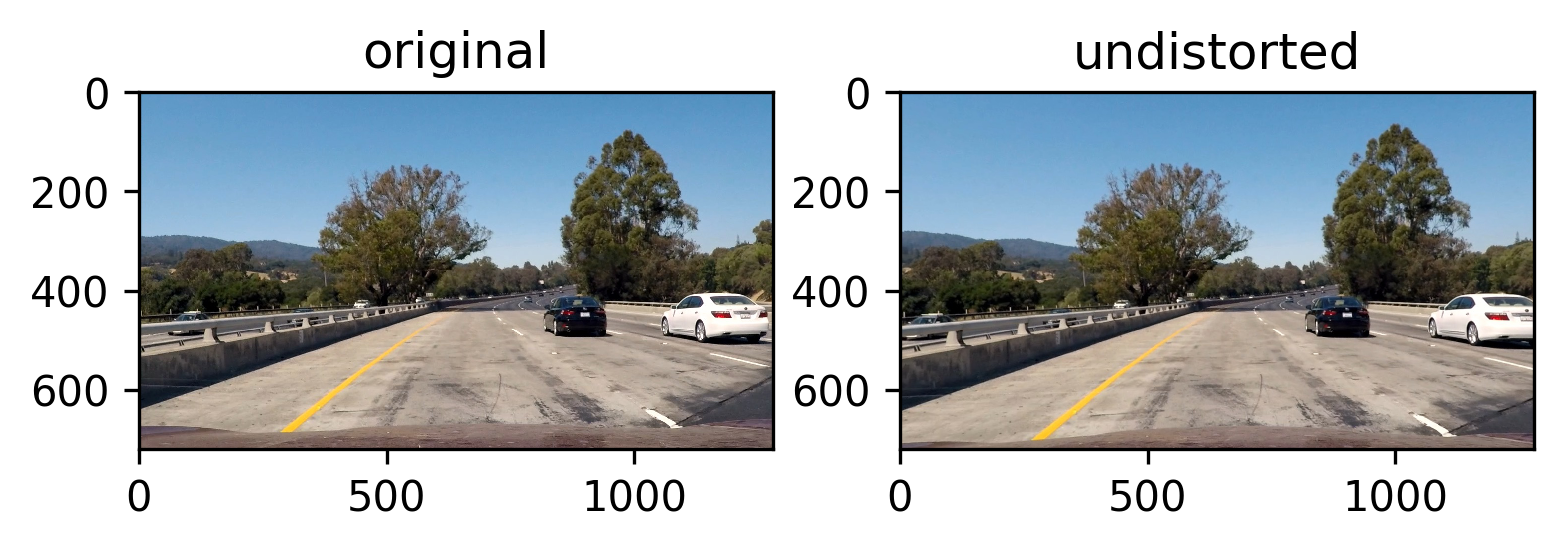

In [7]:
#undistortion image
img = mpimg.imread(test_imgs + "test1.jpg")
#img = mpimg.imread(test_imgs + "straight_lines2.jpg")

imgSize = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgSize, None, None)
dstImage = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(dpi=300)
plt.subplot(1,2,1), plt.imshow(img), plt.title('original')
plt.subplot(1,2,2), plt.imshow(dstImage), plt.title('undistorted')


# Color space and Threshold
I combined several threshold methods(i.e., HLS color transform, absoulute/magnitude gradients and direction gradients) to create a binary images containing the lane pixels. There is no ground truth here, I tested threshold method with manual parameter tunning.
When I calculate the gradient, I directly used converted color space image besides using color thresholded binary image. I tested Gray, HLS and HSV color space, and using HLS color space's S-channel was the best for me.

Here are the some results below:

In [8]:
# Color space transform
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    #cvtImg = gray
    cvtImg = hls[:,:,2] #s-channel
    #cvtImg = hsv[:,:,1] #s-channel
    
    if orient=='x':
        sobel = cv2.Sobel(cvtImg, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(cvtImg, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    #cvtImg = gray
    cvtImg = hls[:,:,2] #s-channel
    #cvtImg = hsv[:,:,1] #s-channel
    
    sobelx = cv2.Sobel(cvtImg, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(cvtImg, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Apply threshold
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    #cvtImg = gray
    cvtImg = hls[:,:,2] #s-channel
    #cvtImg = hsv[:,:,1] #s-channel
    
    sobelx = cv2.Sobel(cvtImg, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(cvtImg, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Apply threshold
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary


In [9]:
ksize = 15
thresh = (20,200)
dirThresh = (np.pi/4, np.pi/3)

(<matplotlib.image.AxesImage at 0x7f82c020b4e0>,
 (-0.5, 1279.5, 719.5, -0.5))

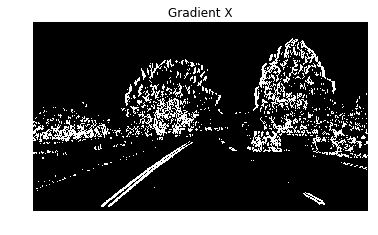

In [10]:
gradx = abs_sobel_thresh(dstImage, orient='x', sobel_kernel=ksize, thresh=(20,200))
plt.imshow(gradx,cmap='gray'), plt.title('Gradient X'), plt.axis('off')

(<matplotlib.image.AxesImage at 0x7f82c0179748>,
 (-0.5, 1279.5, 719.5, -0.5))

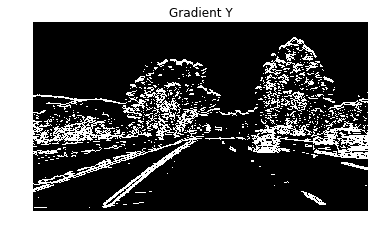

In [11]:
grady = abs_sobel_thresh(dstImage, orient='y', sobel_kernel=ksize, thresh=(20,200))
plt.imshow(grady,cmap='gray'), plt.title('Gradient Y'), plt.axis('off')

(<matplotlib.image.AxesImage at 0x7f82c00e0080>,
 (-0.5, 1279.5, 719.5, -0.5))

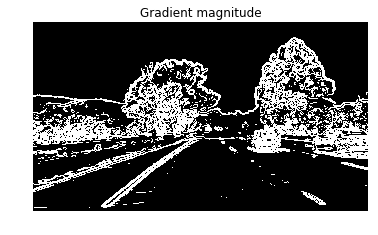

In [12]:
mag_binary = mag_thresh(dstImage, sobel_kernel=ksize, mag_thresh=(20,200))
plt.imshow(mag_binary,cmap='gray'), plt.title('Gradient magnitude'), plt.axis('off')

(<matplotlib.image.AxesImage at 0x7f82c4ff3cf8>,
 (-0.5, 1279.5, 719.5, -0.5))

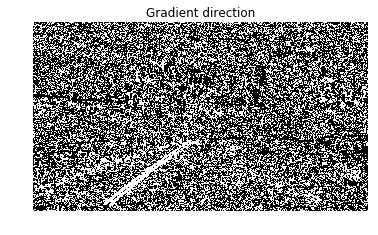

In [13]:
dir_binary = dir_threshold(dstImage, sobel_kernel=ksize, thresh=(0.7,1.3))
plt.imshow(dir_binary,cmap='gray'), plt.title('Gradient direction'), plt.axis('off')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f82c01ab7b8>,
 <matplotlib.text.Text at 0x7f82c011d588>)

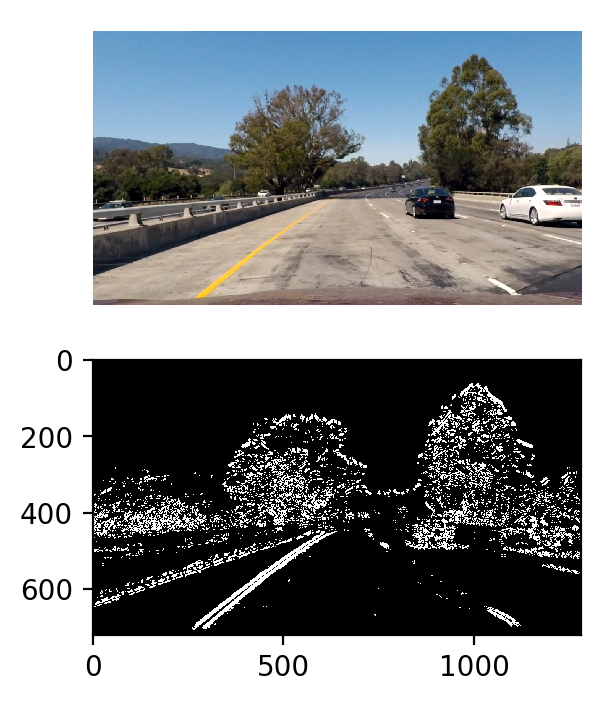

In [14]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


plt.figure(dpi=200)
plt.subplot(2,1,1),plt.imshow(dstImage),plt.axis('off')
plt.subplot(2,1,2),plt.imshow(combined, cmap='gray'),plt.title("")

# Perspective Transform
I used OpenCV function to correctly rectify each image to a bird-eye view.
* Define the source 4 points of rectangle shape onto the road image. I used the straight-lane image to set perspective source points correctly.
* Find the perspective transform matrix using cv2.getPerspectiveTransform function.
* Based on perspective transform matrix, we get warped images using cv2.warpPerspective function.



In [15]:
#set source corners
srcPoint = np.float32([
    [585,460], #585,460
    [203,720], #200,720
    [1127,720],#1108,720
    [695,460]  #710,460
])
#set destinatino corners
dstPoint = np.float32([
    [320,0],
    [320,720],
    [960,720],
    [960,0]    
])

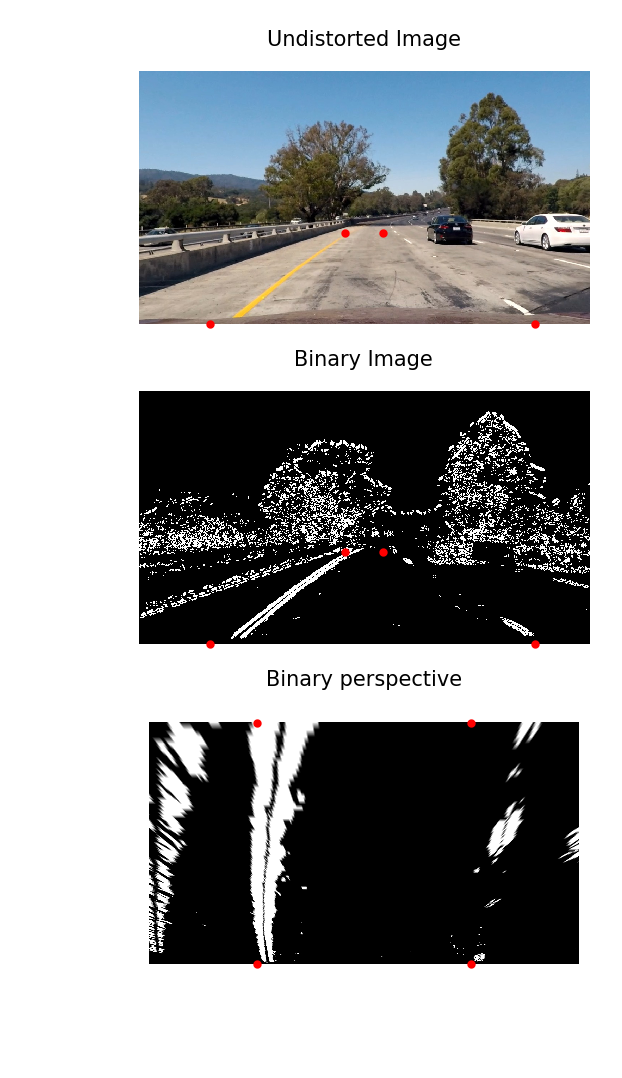

In [16]:
#get PerspectiveTransform
M = cv2.getPerspectiveTransform(srcPoint, dstPoint)
Minv = cv2.getPerspectiveTransform(dstPoint, srcPoint)

warpedImage = cv2.warpPerspective(combined, M, imgSize)

plt.figure(dpi=300)
plt.subplot(3,1,1),plt.imshow(dstImage),
plt.title('Undistorted Image',fontsize=5),plt.axis('off')
x,y = srcPoint.T
plt.scatter(x,y, s=1, color='r')

plt.subplot(3,1,2),plt.imshow(combined, cmap='gray'),
plt.title('Binary Image',fontsize=5),plt.axis('off')
plt.scatter(x,y, s=1, color='r')

plt.subplot(3,1,3),plt.imshow(warpedImage, cmap='gray'),
plt.title('Binary perspective',fontsize=5),plt.axis('off')
x,y = dstPoint.T
plt.scatter(x,y, s=1, color='r')


# Lane detection and Curve Fitting
Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane.
* First I take a histogram along all the columns in the lower half of the images.
* With this histogram I used the sliding window approach to find the places around the line centers in each discrete windows.
* 9 windows used. Margin was 100 pixels.
* Based on each windows center points, It can fit a polynomial to those pixel points.
* Finally, we can get a smooth poly-fitted curve lines.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f82c50b6828>,
 (-63.950000000000003, 1342.95, -17.625390625000001, 370.13320312500002))

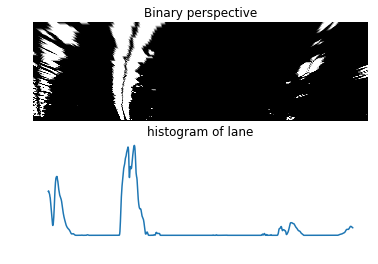

In [17]:
hist = np.sum(warpedImage[warpedImage.shape[0]//2:,:], axis=0) 
plt.subplot(2,1,1),plt.imshow(warpedImage, aspect='auto', cmap='gray'),plt.title("Binary perspective"),plt.axis('off')
plt.subplot(2,1,2),plt.plot(hist),plt.title("histogram of lane"),plt.axis('off')

In [18]:
def sliding_window_lane_finding(img, nwindows=9, margin = 100, minpix = 50, init_frame=False):
    histogram = np.sum(img[img.shape[0]//2:, :], axis=0)
    out_img = (np.dstack((img, img, img))*255).astype(np.uint8)


    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = nwindows
    window_height = np.int(img.shape[0]/nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = margin
    # Set minimum number of pixels found to recenter window
    minpix = minpix
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    
    return out_img, left_fit, right_fit

In [19]:
out_img, left_fit, right_fit = sliding_window_lane_finding(
    warpedImage,
    nwindows=9,
    margin = 100,
    minpix = 10,
    init_frame=False)

(720, 0)

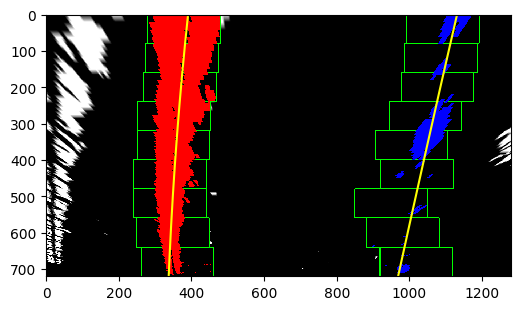

In [20]:
# Generate x and y values for plotting
ploty = np.linspace(0, warpedImage.shape[0]-1, warpedImage.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(dpi=100)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Calculate Radius of curvature and Position of Vehicle
The radius of curvature at any point x of the function x = f(x) is given as follow:
![Rcurve](http://bit.ly/2yc4JYK)
Using this equation for radius of curvature, we can get poly fitted curve's radius. But calculated curve radius based on pixel values, so the radius is not the same as real world values in meters.

To convert radius to physical value from pixel value, we assume that the lane is about 30 meters long and 3.7 meters wide. Finally, we can get physical value of curve radius using those conversion factors.

* refer : http://www.intmath.com/applications-differentiation/8-radius-curvature.php

In [21]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

In [22]:
left_curverad, right_curverad

(11179.605599381795, 62403.334477222685)

In [23]:
# Convert Radius to physical value from pixel value
# 30 m long and 3.7 m wide
ym_per_pix = 30./720.
xm_per_pix = 3.7/700.

left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

In [24]:
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

center_point_from_leftfit = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
center_point_from_rightfit = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
center_offset = ((center_point_from_leftfit + center_point_from_rightfit)/2. - 1280/2.)*xm_per_pix

* First we assume that camera is mounted on center of the vehicle.
* To estimate the center offset from the each lane, we can calculate the y-intercept value from the fitting coefficient.(y = ax^2 + bx + c)
* Comparing the estimated center position and middle pixel of the image in y-axis, we can find the center offset values.

In [25]:
print("Left CurvRadius: {:.3f}m\nRight CurvRadius: {:.3f}m\nCenter offset: {:.3f}m".format(left_curverad, right_curverad, center_offset))

Left CurvRadius: 3662.557m
Right CurvRadius: 19127.276m
Center offset: 0.070m


# Warp Back image and overlay
* The images from the rectified region has been warped back to the original image and plotted to identify the lane boundaries.
* Bird views, threshold views and curve radius values overlayed onto original image.

(<matplotlib.figure.Figure at 0x7f82ac464c50>,
 <matplotlib.text.Text at 0x7f82ac0a5908>)

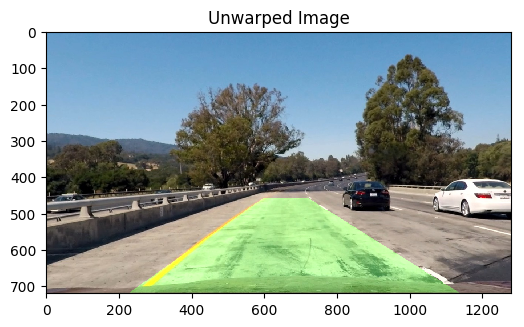

In [47]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warpedImage).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(dstImage, 1, newwarp, 0.3, 0)

plt.figure(dpi=100),plt.imshow(result),plt.title("Unwarped Image")

In [48]:
combinedColor = cv2.cvtColor((combined*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
warpedImageColor = cv2.cvtColor((warpedImage*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
combinedColor.shape, warpedImageColor.shape

((720, 1280, 3), (720, 1280, 3))

(<matplotlib.figure.Figure at 0x7f82a7fd56d8>,
 <matplotlib.image.AxesImage at 0x7f82a7f5ff60>)

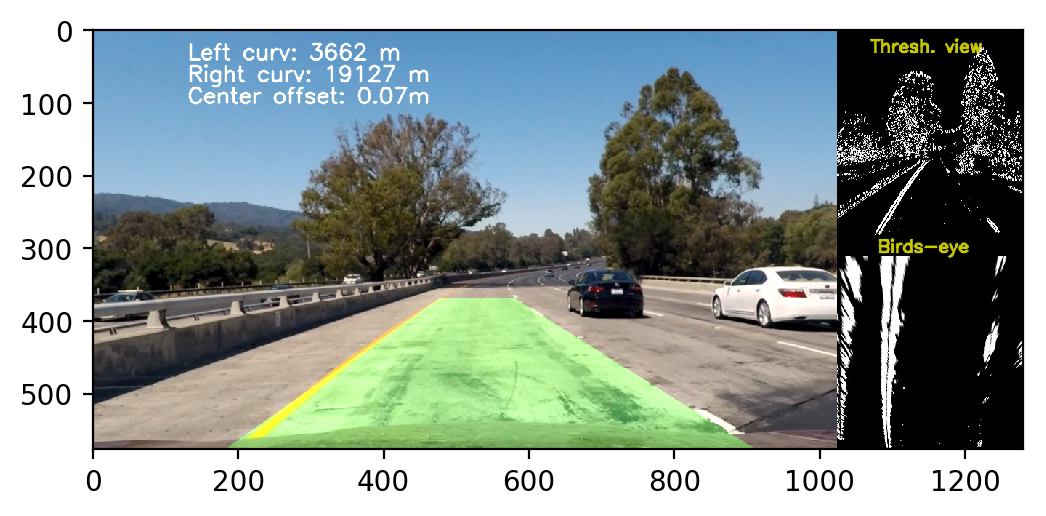

In [50]:
#Combine images
#refer : https://github.com/asgunzi/ArnaldoGunzi_CarNDAdvancedLaneFinding/advancedLine.ipynb
img_out = np.zeros((576,1280,3), dtype=np.uint8)
img_out=np.zeros((576,1280,3), dtype=np.uint8)

#a) Unwarped Lane
img_out[0:576,0:1024,:] =cv2.resize(result,(1024,576))
#b) Threshold
img_out[0:288,1024:1280,:] =cv2.resize(combinedColor,(256,288))
#c)Birds eye view
img_out[310:576,1024:1280,:] =cv2.resize(warpedImageColor,(256,266))

#Write curvature and center in image
TextL = "Left curv: " + str(int(left_curverad)) + " m"
TextR = "Right curv: " + str(int(right_curverad))+ " m"
TextC = "Center offset: " + str(round(center_offset,2)) + "m"
fontScale=1
thickness=2
fontFace = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

cv2.putText(img_out, "Thresh. view", (1070,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
cv2.putText(img_out, "Birds-eye", (1080,305), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)

plt.figure(dpi=200),plt.imshow(img_out)

In [ ]:
def processImage():
    pass

# Result (image, video)
* The image processing pipeline was applied to find the lane lines from images and video.
* The output image here created as a new image where the combination of lanes regions, curve radius and center offset.

In [51]:
from moviepy.editor import VideoFileClip
output = 'out_test_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
out_clip = clip1.fl_image(processImage)
%time out_clip.write_videofile(output, audio=False)

ImportError: No module named 'moviepy'

# Conclusion

Using advanced computer vision algorithm (Undistortion, Color space transform, Gradient threshold, Sliding windows and Perspective projection), we can easily get the lane detection program. But it's not enough to adapt in real situations. In different roads, weathers and brightness, there are chance to fail detecting lane lines. To come up with this shortcoming, we may use deep learning based feature extraction technique(CNN) in various situation.

* Improvements
  * Test different color space (YUV, RGB)
  * Test gradient threshold through CNN extracted feartures. CNN is powerful fearture extractor from images. I think we may have different results from conventional computer vision technique using pretrained CNN feature as inputs to gradient threshold calculator.

## reference
* https://chatbotslife.com/advanced-lane-line-project-7635ddca1960
* udacity SDC nanodegree P4 lesson scripts.